In [3]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = torch.device("cpu")
dtype = torch.float32

In [5]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [6]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=device) for seq in sequences]

In [7]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh]).to(device)
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [60]:
import importlib
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/home/scrotti/Aptamer2025py/callback.py'>

In [61]:
L, q = sequences_oh[0][0].shape
k = torch.log(fi0)
h = torch.zeros(L, q, dtype=dtype, device=device)
J = torch.zeros(L, q, L, q, dtype=dtype, device=device)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1],[1]]).to(device)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
indep = energy_models.IndepSites(h)
ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [62]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [63]:
n_chains = 10**4

chains = training.init_chains(n_rounds, n_chains, L, q, device, dtype)
log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

In [64]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [65]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
n_sweeps = 10
lr = 0.001
target_pearson = 1
max_epochs = 2000

%lprun -f training.train training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson, callbacks=callbacks)

 0.00%[                             ] Epoch: 0/2000 [00:00, ?it/s]

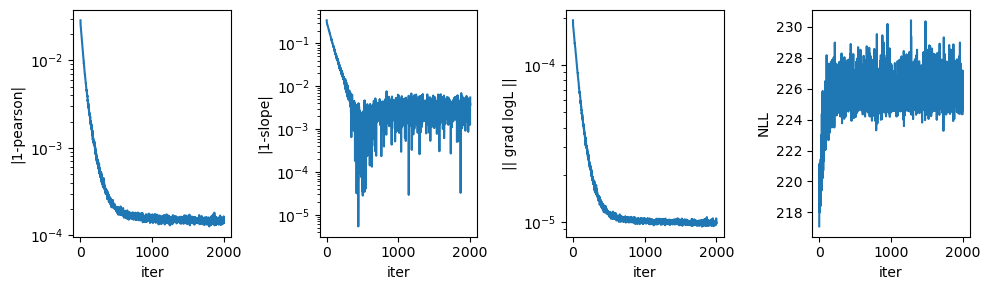

In [70]:
callbacks[0].plot();

(0.0, 1.1)

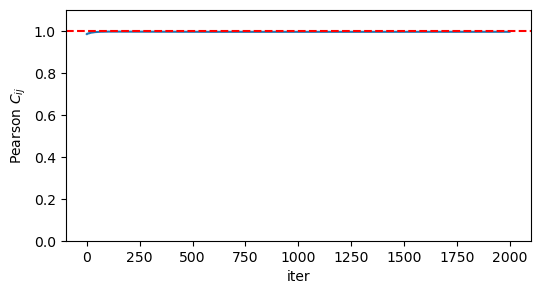

In [71]:
fig, ax = callbacks[1].plot()
ax.axhline(1, color='r', linestyle='--')
ax.set_ylim((0,1.1))

<IPython.core.display.Latex object>

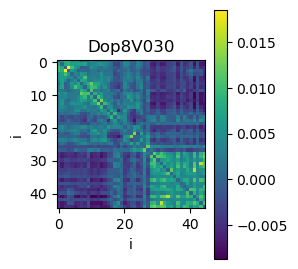

In [72]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge()
# potts_zerosum = potts

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
# im.set_clim(-0.0015, 0.0030)
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))